# Clasificación de imágenes satélites con red neuronal convolucional (CNN), utilizando Keras con GPU en Colab

## Maestría en Electrónica - Tecnológico de Costa Rica
Curso de Reconocimiento de Patrones - Proyecto Final

## Esteban Martínez Valverde
email: estemarval@gmail.com


## Shipsnet Dataset
El conjunto de datos que se utilizo, se compone de imagenes 80x80px con una etiqueta en el nombre de cada archivo, indicando si hay o no un barco en la imagen.
El acceso a Kaggle del set de datos se puede encontrar [aquí](https://www.kaggle.com/rhammell/ships-in-satellite-imagery/home) 

Se recomienda descargar el set de datos directamente del siguiente url: [https://goo.gl/xsKgWb](https://goo.gl/xsKgWb)


![alt text](https://preview.ibb.co/cV0NQ9/lb_3.png)

## Red Neuronal Convolucional CNN
El modelo que vamos a crear se llama Red Neuronal Convolucional (CNN). Las CNN fueron propuestas por primera vez en este documento de 1998 por Yann LeCun (et al.). Pero las CNN no se convirtieron en algo común hasta las recientes mejoras de hardware en forma de GPU y TPU avanzados. 

El **deep learning** es una clasificación que se produce cuando estamos hablando de una red neuronal con 2 o más capas. Donde una capa es básicamente una unidad computacional. Se puede tener una capa llamada "multiplicar por 5" que multiplica cada 5 por 5. Podría alimentar a una capa "multiplicar 10" que toma la salida de la capa "multiplicar por 5" y la multiplica por 10. En En el caso de los CNN, el tipo de capa prominente que se usa es una "capa convolucional", que convoluciona la entrada para producir una salida.

El proceso de convulución en imagenes requiere de toda una explicación formal, pero a manera ilustrativa se presenta la siguiente imagen donde se observa el proceso de convuloción de una entrada (5x5) con un **Kernel** (3x3). El cuadro azul es la entrada, y el cuadro verde es la salida.

![alt text](http://deeplearning.net/software/theano/_images/numerical_no_padding_no_strides.gif)



# Carga de datos
Se realiza un '*upload*  del  archivo **shipsnet.zip**,  desde el computador local (donde se visualiza este *notebook*),  y se descomprimen todas las imagenes tipo **.png**  en una carpeta de una maquina virtual de Google. En cada nueva sesión, se crea una nueva maquina virtual para cada usuario, por lo que este proceso se debe realizar al inicio de cada sesión.


In [12]:
#@title Parámetros de datos { output-height: 200 }

## CARGA IMAGENES A MAQUINA VIRTUAL ##

# Importa las librerías necesarias
import zipfile
import os

# Define los parametros para la carga de las imagenes
# Nombre del archivo .zip a cargar
zip_file = "shipsnet.zip" #@param {type:"string"}
# Direccion de carpeta a descomprimir
folder_path = "shipsnet" #@param {type:"string"}  

if not os.path.exists(zip_file):
  from google.colab import files
  uploaded = files.upload()
else:
  print('El archivo "'+zip_file+'" ya existe!' )
  
  
def delete_unzzip(folder_path): # borra carpeta y descomprime
  os.makedirs(folder_path)
  zip_ref = zipfile.ZipFile(zip_file, 'r')
  zip_ref.extractall(folder_path)
  zip_ref.close()
  print("zip descomprimido en /"+ folder_path)

if not os.path.exists(folder_path):#Descomprime el archivo .zip que contiene las imagenes
  delete_unzzip(folder_path)   
    
elif len(os.listdir(folder_path))==0:
  print("Carpeta sin archivos, borrando y creando de nuevo...")    
  os.rmdir(folder_path)
  delete_unzzip(folder_path)
else:
  print('Imagenes ya guardadas en la Maquina Virtual!' )

El archivo "shipsnet.zip" ya existe!
Imagenes ya guardadas en la Maquina Virtual!


Se comprueba la disponibilidad del uso de GPU para el uso TensorFlow como *backend* de Keras. Además se habilita el crecimiento de la memoria del GPU para asegurar que siempre se dispondrá de memoria para ejecutar los procesos.

Esta funcionalidad debe de habilitarse en el Menu: **Edit>Notebook Settings**, donde se selecciona **GPU** en la opción **Hardware accelerator** 

![alt text](https://image.ibb.co/ijsYXp/colab_tut_1.png)



In [13]:
## COMPROBAR DISPOSITIVO GPU ##

# Importa las librerías necesarias
import tensorflow as tf

# Comprueba la existencia de un GPU para utilizar tensorflow
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('Dispositivo GPU no encontrado!!!')
else:
  print('Dispositivo GPU en posicion: {}'.format(device_name))

# Habilita el crecimiento de la memoria en el GPU 
# Si existen otros proyectos con sesion abierta consumiran memoria
# y no se podra ejecutar la prediccion 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

Dispositivo GPU en posicion: /device:GPU:0


# Preprocesado de Imagenes
Los datos de entrada son las imagenes con dimesiones de 80x80x3, lo que quiere decir tienen un tamaño de  **80x80 px** y una profundidad de **3 canales RGB** (Red, Green, Blue). Mientras que los datos de salida (etiquetas), se obtienen del nombre de las imagenes donde se indica **0 ->no hay barco y 1->hay barco**.

Se utiliza **numpy** para dividir el conjunto de datos (imagenes y etiquetas), en dos conjuntos de datos para testing y para training. En este caso se utilizó **80% para training** y **20% para testing**. Se deben definir los parametros de la ubicación de la carpeta y el porcentaje para training. Se aplica la función **random.permatuation()** para que se reordenen los conjuntos de datos aleatoriamente.




In [14]:
#@title Ubcación de las imagenes { form-width: "350px" }

##DIVIDE TRAIN/TEST SETS##

# Importa las librerías necesarias
import glob
import os
import numpy as np
import os.path as path
from scipy import misc
import time

# Define la ubicación de la carpeta donde 
# se encuentran las imagenes
IMAGE_PATH = "shipsnet/shipsnet" #@param {type:"string"}

# Divide los set de datos en 'testing' y 'training'
TRAIN_TEST_SPLIT = 0.8 #@param {type:"slider", min:0, max:1, step:0.05}


# Carga la imagenes
file_paths = glob.glob(path.join(IMAGE_PATH, '*.png'))
images = [misc.imread(path) for path in file_paths]
images = np.asarray(images)
print('Total imagenes: ' + str(len(images)))

# Obtiene las dimensiones de las imagenes
image_size = np.asarray([images.shape[1], 
                         images.shape[2], 
                         images.shape[3]])
print('Dimensiones de las imagenes: ' + str(image_size[0]) + 'x' + str(image_size[1]) + 'x'  + str(image_size[2]))

# Realiza un escalamiento del tamano
images = images / 512

# Lee los 'labels' del nombre de los archivos
# 0->NO hay barco, 1->HAY barco
n_images = images.shape[0]
labels = np.zeros(n_images)
for i in range(n_images):
    filename = path.basename(file_paths[i])[0]
    labels[i] = int(filename[0])


# Dividir en un índice dado
split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

# Dividir las imágenes y las etiquetas
x_train = images[train_indices, :, :]
y_train = labels[train_indices]
x_test = images[test_indices, :, :]
y_test = labels[test_indices]

Total imagenes: 4000
Dimensiones de las imagenes: 80x80x3


# Visualización de datos
Se muestan 10 imagenes etiquetadas con 1-> Hay Barco, y 10 imagenes con 0-> No hay barco.

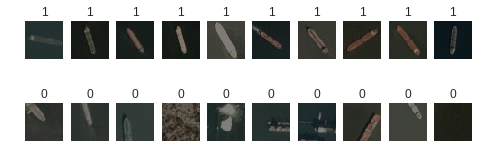

In [15]:
## VISUALIZACION DE DATOS ##

# Importa las librerías necesarias
import matplotlib.pyplot as plt

# Se define una función para visualizar las imagenes
def visualize_data(positive_images, negative_images):
    # PARAMETROS DE ENTRADA
    # positive_images: - imagenes con LABEL = 1 (Barco)
    # negative_images: - imagenes con LABEL = 0 (NO barco)

    figure = plt.figure()
    count = 0
    for i in range(positive_images.shape[0]):
        count += 1
        figure.add_subplot(2, positive_images.shape[0], count)
        plt.imshow(positive_images[i, :, :])
        plt.axis('off')
        plt.title("1")

        figure.add_subplot(1, negative_images.shape[0], count)
        plt.imshow(negative_images[i, :, :])
        plt.axis('off')
        plt.title("0")
    plt.show()


# Numero de ejemplos positivos y negativos a mostrar
N_TO_VISUALIZE = 10

# N muestras de los ejemplos Positivos
positive_example_indices = (y_train == 1)
positive_examples = x_train[positive_example_indices, :, :]
positive_examples = positive_examples[0:N_TO_VISUALIZE, :, :]

# N muestras de los ejemplos Negativos
negative_example_indices = (y_train == 0)
negative_examples = x_train[negative_example_indices, :, :]

negative_examples = negative_examples[0:N_TO_VISUALIZE, :, :]

# Llama a la funcion de visualizar datos con los ejemplos muestreados
visualize_data(positive_examples, negative_examples)

# Creación del Modelo CNN

La conformación del modelo CNN que se obtuvo se compone de 4 capas convulucionales (con ReLu), una capa de *max-pooling* (con ReLu) y una ultima de *dropout*. En la capa de salida se utilizó una función de activación tipo *sigmoid*. La capa de *dropout* se encarga de  "desactivar" las neuronas que aportan muy poco en los pesos de entrenamiento generados. Por lo que se realizaron pruebas **con y sin** **  *dropout* ** obteniendo una precision de **98.2 y 97.4**, respectivamente.
Los Hiperparametros que se seleccionaron después de realizar diferentes pruebas son:

*   Número de capas = 4
*   Minimo de Neuronas = 20
*   Máximo de Neuronas = 100
*   Drop Rate = 0.5

Obteniendo un total de 10,440,941 parámetros totales y entrenables.

In [16]:
#@title Hiperparametros del Modelo { form-width: "200px" }

## CREACION DEL MODELO CNN ##

# Importa las librerías necesarias
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score, f1_score
from datetime import datetime

# Se definen los Hiperparametros del Modelo
# Se utiliza el FORM para mejor visualización
N_LAYERS = 4 #@param {type:"number"}
MIN_NEURONS = 20 #@param {type:"number"}
MAX_NEURONS = 100 #@param {type:"number"}
DROP_RATE = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}
KERNEL = (3, 3)

#Se define la funcion cnn()
# PARAMETROS DE ENTRADA
    # size     - tamano de las imagenes de entrada
    # n_layers - numero de capas
    # min_layers - minimo de neuronas en la CNN  
    # max_layers - maxmo de neuronas en la CNN
    # kernel      - tamano del kernel en la CNN
# SALIDAS DE LA FUNCION
    # model    - CNN compilada
def cnn(size, n_layers,min_layers,max_layers,kernel):  
    # Determina el # de neuronas en cada capa de convolucion
    steps = np.floor(max_layers / (n_layers + 1))
    nuerons = np.arange(min_layers, max_layers, steps)
    nuerons = nuerons.astype(np.int32)

    # Define el tipo de modelo 'Seqcuencial'
    model = Sequential()
    # Agrega las capas de convolucion
    for i in range(0, n_layers):
        if i == 0:
            shape = (size[0], size[1], size[2])
            model.add(Conv2D(nuerons[i], kernel, input_shape=shape))
        else:
            model.add(Conv2D(nuerons[i], kernel))

        model.add(Activation('relu'))

    
    
    
    # Agrega la capa de max-poling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())    
    model.add(Dense(max_layers))
    model.add(Activation('relu'))
    
    #Agrega la capa de dropout
    model.add(Dropout(DROP_RATE))
    
    
    # Agrega la capa de salida
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
        

    # Compila el modelo
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])    
    return model
  
# Se llama la funcion de la CNN con los parametros definidos previamente
model = cnn(size=image_size, n_layers=N_LAYERS,min_layers=MIN_NEURONS,max_layers=MAX_NEURONS,kernel=KERNEL)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 78, 78, 20)        560       
_________________________________________________________________
activation_7 (Activation)    (None, 78, 78, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 76, 76, 40)        7240      
_________________________________________________________________
activation_8 (Activation)    (None, 76, 76, 40)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 74, 74, 60)        21660     
_________________________________________________________________
activation_9 (Activation)    (None, 74, 74, 60)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 80)        43280     
__________

# Entrenamiento del Modelo
Para el entraniento se seleccionaron los siguientes Hiperparametros:


*   EPOCHS = 20
*   BATCH SIZE = 20

Con el uso de GPU se dura aproximadamente 197 segundos y sin GPU se dura aproximadamente 4347 segundos, para el entrenamiento del modelo con 80% del dataset (3200 imagenes).



In [17]:
#@title Hiperparametros de Entrenamiento { form-width: "320px" }
## ENTRENAMIENTO DEL MODELO ##

# Se definen los Hiperparametros de Entrenamiendo
EPOCHS = 20 #@param {type:"slider", min:1, max:100, step:1}
BATCH_SIZE = 20 #@param {type:"slider", min:1, max:100, step:1}

# Se define el parametro para 'Early stopping callback'
PATIENCE = 10


#Se define la funcion train_model()
# PARAMETROS DE ENTRADA
  # epochs     - # de veces que se utiliza el set de datos COMPLETO
  # batch_size - # de ejemplos de entranamiento presentes en un BATCH
  # patience   - patience early stopping
# El numero de iteraciones es el numero de BATCHES necesarios para completar un EPOCH     
def train_model(epochs,batch_size,patience):
  early_stopping = EarlyStopping(monitor='loss', 
                                 min_delta=0, 
                                 patience=patience, 
                                 verbose=0, 
                                 mode='auto')
  # Se llama el 'TensorBoard callback'
  # Se define una direccion para guardar los 'LOG'
  LOG_DIRECTORY_ROOT = 'logdir'
  now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
  log_dir = "{}/run-{}/".format(LOG_DIRECTORY_ROOT, now)
  tensorboard = TensorBoard(log_dir=log_dir, 
                            write_graph=True, 
                            write_images=True)
  #!tensorboard --logdir LOG_DIRECTORY_ROOT
  
  # define los callbacks en una lista
  callbacks = [early_stopping, tensorboard]

  # Se entrena el modelo y se toma el tiempo que toma
  start = time.time()
  history = model.fit(x_train, 
                      y_train,
                      validation_split=0.33, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      callbacks=callbacks, 
                      verbose=0)
  done = time.time()
  print(str((done - start)) + ' segundos transcurridos')
  
  return model,history

# Se llama la funcion de la CNN con los parametros 
# definidos previamente
model,history = train_model(epochs=EPOCHS,batch_size=BATCH_SIZE,patience=PATIENCE)


197.64543914794922 segundos transcurridos


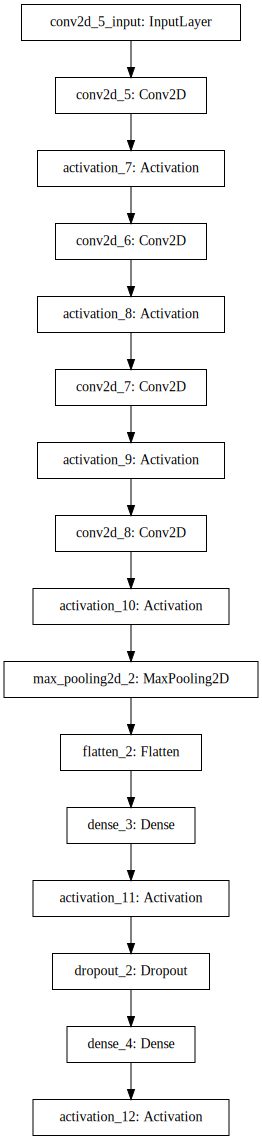

In [23]:
## VISUALIZA EL MODELO DE ENTRENAMIENTO ##

# Instala e importa las librerías necesarias
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz
!pip install -q pydot
import pydot

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.utils import plot_model

#plot_model(model, to_file='model.png')

SVG(model_to_dot(model).create(prog='dot', format='svg'))


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


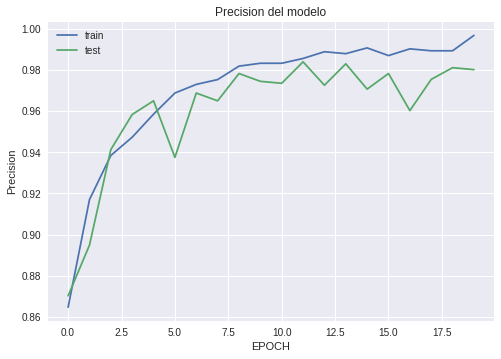

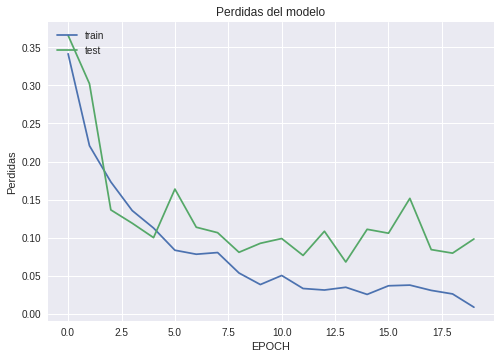

In [19]:
## VISUALIZA EL HISTORIAL DE PERDIDAS Y PRECISION EN EL ENTRENAMIENTO ##

# Muestra los historiales disponibles
print(history.history.keys())

# Grafica la historia de la precision durante el entrenamiento 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Precision del modelo')
plt.ylabel('Precision')
plt.xlabel('EPOCH')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Grafica la historia de las perdidas durante el entrenamiento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdidas del modelo')
plt.ylabel('Perdidas')
plt.xlabel('EPOCH')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluación del Modelo
Se hace una predicción para evaluar la **precisióny F1 Macro** del modelo entrenado, y se obtiene la **matriz de confución** normal y relativa.

In [20]:
## EVALUACION DEL MODELO ##
# Realiza una prediccion en el set de datos de testing

# Importa las librerías necesarias
from sklearn.metrics import confusion_matrix


#Se define la funcion train_model()
# PARAMETROS DE ENTRADA
    # n_layers - numero de capas
    # min_layers - minimo de neuronas en la CNN  
    # max_layers - maxmo de neuronas en la CNN
    # kernel      - tamano del kernel en la CNN
# PARAMETROS DE SALIDA    
    # f1 - Precision f1 score
    # accuracy  - accuracy score
    # test_predictions - lista con las predicciones realizadas
    # cm - Matriz de confusion    
def evaluate_model(model,x_test):  
  test_predictions = model.predict(x_test)
  test_predictions = np.round(test_predictions)
  
  # Crea la Matriz de Confusion
  cm = confusion_matrix(y_test, test_predictions)
  
  # Obtiene el puntaje de las precisiones 
  accuracy = accuracy_score(y_test, test_predictions)
  f1 = f1_score(y_test, test_predictions, average='macro')  
  return accuracy,f1,test_predictions,cm

accuracy,f1,test_predictions,cm = evaluate_model(model,x_test)
print("Accuracy: " + str(accuracy))
print("F1_macro: " + str(f1))  



Accuracy: 0.9825
F1_macro: 0.9775381850853548


Matriz de Confusion NO Normalizada
[[581   7]
 [  7 205]]
Matriz de Confusion Normalizada
[[0.98809524 0.01190476]
 [0.03301887 0.96698113]]


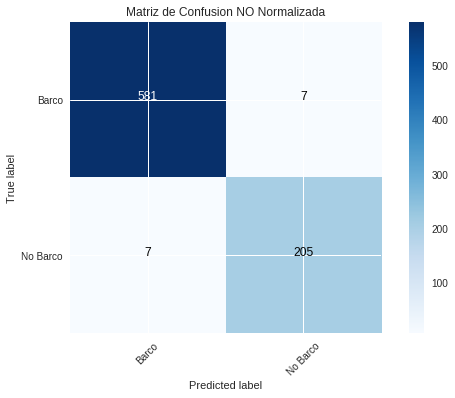

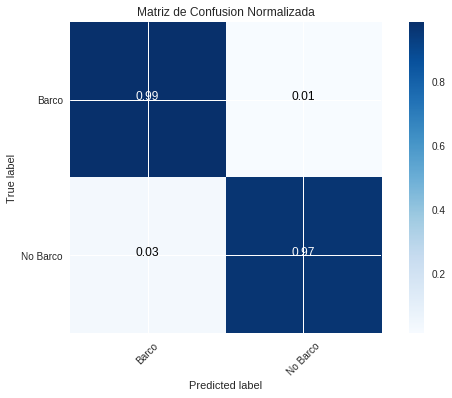

In [21]:
## VISUALIZA LA MATRIZ DE CONFUSION ##

# Importa las librerías necesarias
import itertools
import numpy as np
import matplotlib.pyplot as plt

"""
This function prints and plots the confusion matrix.
Normalization can be applied by setting `normalize=True`.
"""
#Se define la funcion plot_confusion_matrix()
# PARAMETROS DE ENTRADA
    # n_layers - numero de capas
    # min_layers - minimo de neuronas en la CNN  
    # max_layers - maxmo de neuronas en la CNN
    # kernel      - tamano del kernel en la CNN
# PARAMETROS DE SALIDA    
    # f1 - Precision f1 score
    # accuracy  - accuracy score
    # test_predictions - lista con las predicciones realizadas
    # cm - Matriz de confusion    
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    print(title)
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=['Barco', 'No Barco'],
                      title='Matriz de Confusion NO Normalizada')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=['Barco', 'No Barco'], normalize=True,
                      title='Matriz de Confusion Normalizada')

plt.show()

# Visualizacion de Resultados
Se visualizan los errores cometidos en la predicción anterior al modelo entrenado.

Visualizacion de las predicciones incorrectas # 14
Error rate: 1.749999999999996%
(P->Prediccion // R->Real):


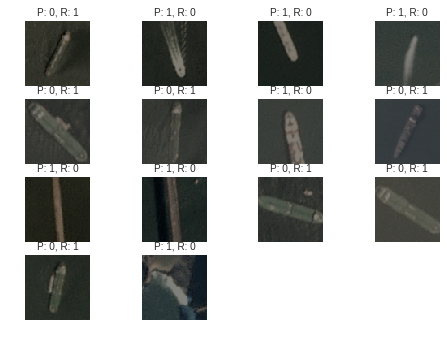

In [22]:
import matplotlib.pyplot as plt
#Se define la funcion visualize_incorrect_labels()
# PARAMETROS DE ENTRADA
# x_data      - imagenes
# y_data      - etiquetas (True/False)
# y_predicted - prediccion de etiquetas (True/False)
def visualize_incorrect_labels(x_data, y_real, y_predicted):    
    total = len(y_real)
    count = 0
    figure = plt.figure()
    incorrect_label_indices = (y_real != y_predicted)
    y_real_WRONG = y_real[incorrect_label_indices]
    y_predicted = y_predicted[incorrect_label_indices]
    x_data = x_data[incorrect_label_indices, :, :, :]

    maximum_square = np.ceil(np.sqrt(x_data.shape[0]))
    for i in range(x_data.shape[0]):
        count += 1
        figure.add_subplot(maximum_square, maximum_square, count)
        plt.imshow(x_data[i, :, :, :])
        plt.axis('off')
        plt.title("P: " + str(int(y_predicted[i])) + ", R: " + str(int(y_real_WRONG[i])), fontsize=10)
    
    errors = i + 1
    error_rate = (1 - (total - errors)/total)*100 
    print('Visualizacion de las predicciones incorrectas # ' + str(errors))      
    print('Error rate: ' + str(error_rate) + '%')
    print('(P->Prediccion // R->Real):')    

    plt.show()
    # return error rate
    

visualize_incorrect_labels(x_test, y_test, np.asarray(test_predictions).ravel())


